In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import scipy
import itertools
import warnings
import math
from pvlib.iotools import read_epw

from IPython.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import calplot



warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

mpl.rcParams['figure.dpi'] = 40

sns.set()

n_clusters = 27

start_folder = '/Users/jgonzal2/EULP/result/clustering'
# type_folders = ['by_utility', 'by_building_type', 'by_utility_and_building_type']
type_folders = ['by_building_type', 'by_utility_and_building_type']
# type_folders = ['by_building_type']

cluster_cols = [f'{k+2}_clusters' for k in range(1,n_clusters+1)]
hourly_cols  = [f'hour_{str(i).rjust(2, "0")}' for i in range(24)]

In [2]:
def define_season(val):
    if val<55:
        return 'winter'
    elif val>=55 and val<70:
        return 'shoulder'
    else:
        return 'summer'
    
def c_to_f(c):
    return (c * 9.0/5.0) + 32.0

def is_weekend(val):
    if val in ['Monday','Tuesday', 'Wednesday', 'Thursday' ,'Friday']:
        return False
    
    return True

weather_data  = {}
weather_metadata  = {}
file_overview = pd.read_csv('/Users/jgonzal2/EULP/data_files/weather_files/weather_file_list_for_ami_analysis.csv')

all_weather_data = pd.DataFrame(columns=['temp_air', 'date_no_time'])

for ix, row in file_overview.iterrows():
    year    = row['year']
    utility = row['utility_name']
    fips    = row['match_FIP']
    
    data, metadata = read_epw(f'/Users/jgonzal2/EULP/data_files/weather_files/{year}_{fips}.epw')
    
    data         = data[['temp_air']]
    data['date'] = data.index.date
    data = data.groupby('date').mean()
    
    data['utility'] = utility
    data['date_no_time'] = pd.to_datetime(data.index, utc=True, format='%Y-%m-%d').date
    
    data['season'] = data['temp_air'].apply(c_to_f).apply(define_season)
    
    if ix == 0:
        all_weather_data = data.copy()
    else:
        all_weather_data = all_weather_data.append(data)
    
    weather_data[f'{year}_{utility}']     = data
    weather_metadata[f'{year}_{utility}'] = metadata

In [3]:
all_weather_data['utility'].unique()

array(['epb', 'cherryland', 'maine', 'seattle', 'fortcollins', 'horry',
       'tallahassee', 'veic'], dtype=object)

In [4]:
def kl_div(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 0.0000001

     # You may want to instead make copies to avoid changing the np arrays.
    P_copy = P.copy().fillna(epsilon)
    Q_copy = Q.copy().fillna(epsilon)
    
    #normalize P, Q
    P_copy = P_copy/P_copy.sum()
    Q_copy = Q_copy/Q_copy.sum()

    divergence = np.sum(P_copy*np.log(P_copy/Q_copy))
    return divergence

In [10]:
class ClusterGraphs:
    
    def __init__(self, start_folder, folder, subfolder):
        self.start_folder   = start_folder
        self.folder         = folder
        self.subfolder      = subfolder
        
        self.cluster_result = pd.read_csv(f'{self.start_folder}/{self.folder}/{self.subfolder}/cluster_result.csv', parse_dates=['date'])
        self.cluster_result = self.cluster_result[self.cluster_result['bad_data']==False]
        self.cluster_result = self.cluster_result.rename(columns = {'data_type':'utility'})
        self.cluster_result['date_no_time'] = pd.to_datetime(self.cluster_result['date'], utc=True, format='%Y-%m-%d').dt.date
        self.cluster_result['weekend'] = self.cluster_result['day_of_week'].apply(is_weekend)
        
        self.cluster_data   = self.cluster_result[cluster_cols]
        self.hourly_data    = self.cluster_result[hourly_cols]
        
        self.n_clusters     = 27
        self.clusters       = self.cluster_data['29_clusters'].unique()
        self.calc_clusters  = len(self.clusters)
        
        self.maxval_1 = None
        self.maxval_2 = None
        self.maxval_3 = None
        
        # merge cluster results with weather files
        self.cluster_result = pd.merge(self.cluster_result, all_weather_data, on = ['date_no_time', 'utility'], how='left').drop('date_no_time', axis=1)
            
        self.cluster_result.to_csv('test_result_csv_with_weather.csv')
        
        

    def get_maxval_1(self, data):
        if self.maxval_1 is None:
            
            self.maxval_1 = data.groupby('cluster_group').mean().max().max()

            if self.maxval_1 <= 1:
                return 1.05
            return 1.5
        
        return self.maxval_1
    
    
    # sort the values in the pivot_freq[col] series by frequency in descending order
    # keep all values whose sum does not exceed the percentile
    # include the last value that makes the sum >= the percentile
            
    # example, percentile = 0.90
    # values   = [0.4, 0.05, 0.2, 0.1, 0.2, 0.05]
    # selected = [0.4, nan, 0.2, 0.1, 0.2, nan]
    def get_cluster_percentile(self, pivot, percentile):
        pivot      = pivot.copy()
        pivot_freq = pivot.copy()
        
        for col in pivot_freq.columns:
            pivot_freq[col] = pivot_freq[col]/pivot_freq[col].sum()
            
            temp_sum = 0
            temp_series = pivot_freq[col].sort_values()
            temp_series = temp_series[::-1]
            
            for value in temp_series:
                
                if pd.isna(value):
                    continue
                temp_sum += value
                
                if temp_sum >= percentile:
                    smallest_value = value
                    break
            
            pivot_freq[col] = pivot_freq[col].apply(lambda x: x if x >= smallest_value  else np.nan)
            mask = pivot_freq[col].isna()
            
            temp = pivot[col]
            temp[mask] = np.nan
            
            pivot[col] = temp
            
        return pivot
        
        
    # Plot the load profiles for each cluster group for each building type, varying k
    def plot_graph_1(self, show):
            
            ## GRAPH 1
            # plot mean load shape for k-means range from k=2 to k=n_clusters
            fig, axes = plt.subplots(nrows=self.n_clusters-1, ncols=1, figsize=(8,75))

            for k in range(1,self.n_clusters):
                data_to_plot = self.hourly_data.copy()
                data_to_plot['cluster_group'] = self.cluster_data[f'{k+2}_clusters'].copy()
                
                if k == 1:
                    self.maxval_1 = self.get_maxval_1(data_to_plot)

                data_to_plot.groupby('cluster_group').mean().T.plot(ax=axes[k-1],legend=None)

                axes[k-1].set_ylim([-.03, self.maxval_1*1.05])
                axes[k-1].set_xlim([0,23])

                axes[k-1].set_ylabel(f'k = {k+1}, load / load_99')

                plt.suptitle(f'Clustering results for {self.subfolder} load profiles, n={len(self.cluster_result)} profiles')

            handles, labels = axes[-1].get_legend_handles_labels()
            fig.legend(handles, labels, loc='lower center', ncol = int((self.n_clusters+3)/4), title="Cluster Groups")#, mode = "expand")
            fig.tight_layout()
            fig.subplots_adjust(top=0.975)
            fig.subplots_adjust(bottom=0.03)

            plt.savefig(f'{self.start_folder}/{self.folder}/{self.subfolder}/load_profile_cluster_groups.png')

            if show:
                plt.show()
            else:
                plt.close('all')
            
            
    # Plot the load profiles for each cluster group for each building type    
    def plot_graph_2(self, show):

            data_to_plot = self.hourly_data.copy()
            data_to_plot['cluster_group'] = self.cluster_data[f'{self.n_clusters+2}_clusters'].copy()

            self.maxval_1 = self.get_maxval_1(data_to_plot)

            mean_data_to_plot = data_to_plot.groupby('cluster_group').mean().T

            fig, axes = plt.subplots(nrows=math.ceil(len(mean_data_to_plot.T)/6.0), ncols=math.ceil(len(mean_data_to_plot.T)/5.0), figsize=(40,20))

            for k, ax in enumerate(axes.reshape(-1)):
                if k >= len(mean_data_to_plot.T):
                    continue

                mean_data_to_plot[[k]].plot(ax=ax, legend=None)

                frequency = 100.0 * len(data_to_plot[data_to_plot['cluster_group']==k]) / len(data_to_plot) 

                n = len(data_to_plot[data_to_plot['cluster_group']==k])

                ax.set_title(f'cluster {k}, frequency = {frequency:.2f}%, n = {n}')
                ax.set_ylabel('load / load_99')

                ax.set_ylim([-0.03, self.maxval_1*1.05])
                ax.set_xlim([0, 23])

            plt.suptitle(f'Load profile overview for {self.subfolder}, n = {len(data_to_plot)} profiles')

            plt.savefig(f'{self.start_folder}/{self.folder}/{self.subfolder}/load_profile_frequency.png')

            if show:
                plt.show()
            else:
                plt.close('all')


    # Plot the heat map for each building type
    def plot_graph_3(self, show):

            to_pivot = self.cluster_result[['date', f'{n_clusters+2}_clusters']]
            pivot = pd.pivot_table(to_pivot, index='date', columns=f'{self.n_clusters+2}_clusters', aggfunc=len)
            pivot.index = pd.to_datetime(pivot.index, utc=True)
            self.maxval_2 = pivot.max().max()

            data_to_plot = self.hourly_data.copy()
            data_to_plot['cluster_group'] = self.cluster_data[f'{n_clusters+2}_clusters']

            self.maxval_1 = self.get_maxval_1(data_to_plot)

            for year in list(pivot.index.year.unique()):

                pivot_to_plot = pivot[pivot.index.year == year]

                for k in pivot_to_plot.columns:
                    # plot curve
                    fig = plt.figure(constrained_layout = True, figsize = (21,3))
                    gridspec = fig.add_gridspec(nrows=1, ncols = 7)

                    fig_ax_0 = fig.add_subplot(gridspec[0, 0])
                    fig_ax_0.set_ylabel("load / load_99")

                    fig_ax_1 = fig.add_subplot(gridspec[0, 1])
                    fig_ax_1.set_ylabel("load / load_99")

                    sns.set()

                    ## GRAPH 3A
                    # plot all the cluster curves on fig_ax_0
                    # randomly select up to 200 curves to plot for performance purposes
                    data_to_plot[data_to_plot['cluster_group']==k].sample(min(len(data_to_plot[data_to_plot['cluster_group']==k]), 200)).T.plot(ax=fig_ax_0, alpha=0.1, legend=None, color='b')

                    # plot the mean cluster curve on fig_ax_0
                    data_to_plot[data_to_plot['cluster_group']==k].groupby('cluster_group').mean().T.plot(ax=fig_ax_0,legend=None, linewidth=1.25, color='k')

                    fig_ax_0.set_ylim([-.03, self.maxval_1*1.05])
                    fig_ax_0.set_xlim([0,23])

                    # plot the standard deviation curve on fig_ax_1
                    sns.boxplot(data = data_to_plot[data_to_plot['cluster_group']==k].drop('cluster_group', axis=1), showfliers=False, color='b')
                    fig_ax_1.set_xticks([0,5,10,15,20])
                    fig_ax_1.set_ylim([-.03, self.maxval_1*1.05])
                    fig_ax_1.set_xlim([0,23])

                    ## GRAPH 3B
                    # plot heatmap
                    fig_ax_2 = fig.add_subplot(gridspec[0, 2:])

                    cax = calplot.yearplot(pivot_to_plot[pivot_to_plot[k].notnull()][k].resample('D').sum(),
                                    cmap=u'Reds',
                                    how=u'sum',
                                    year=year,
                                    fillcolor=u'whitesmoke',
                                    linewidth=1, 
                                    linecolor=None, 
                                    vmin = 0,
                                    vmax = self.maxval_2,
                                    daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
                                    dayticks=True, 
                                    monthlabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                                    monthticks=True, 
                                    ax=fig_ax_2)

                    divider = make_axes_locatable(cax)
                    lcax = divider.append_axes("right", size="2%", pad=0.75)
                    fig.colorbar(cax.get_children()[1], cax=lcax)

                    frequency = 100.0 * len(data_to_plot[data_to_plot['cluster_group']==k]) / len(data_to_plot)
                    n = int(pivot_to_plot[k].sum())

                    plt.suptitle(f'Load profile overview for {self.subfolder} cluster {k}, {year}, frequency = {frequency:.2f}%, n = {n} profiles')
                    if not os.path.exists(f'{self.start_folder}/{self.folder}/{self.subfolder}/heat_maps'):
                        os.makedirs(f'{self.start_folder}/{self.folder}/{self.subfolder}/heat_maps')
                    
                    plt.savefig(f'{self.start_folder}/{self.folder}/{self.subfolder}/heat_maps/load_profile_heatmap_{year}_cluster_{k}.png', bbox_inches="tight")

                    if show:
                        plt.show()
                    else:
                        plt.close('all')

                    print(f'{subfolder}, {year}, {k}')

    
    # Plot the count of each cluster group for each building type/utility
    def plot_graph_4(self, show, divergence_method):
        if folder != 'by_building_type':
            return

        cluster_cols = ['5_clusters', '10_clusters', '15_clusters', '20_clusters', '25_clusters', '29_clusters']

        fig = plt.figure(figsize=(100,13)) 
        outer_grid = gridspec.GridSpec(nrows = 2, ncols = 1, figure = fig)

        upper_cell = outer_grid[0,0]
        lower_cell = outer_grid[1,0]

        upper_grid = gridspec.GridSpecFromSubplotSpec(1, len(cluster_cols), upper_cell, width_ratios=[8,9,14,19,24,28])
        lower_grid = gridspec.GridSpecFromSubplotSpec(1, len(cluster_cols), lower_cell, width_ratios=[8,9,14,19,24,28])

        for i, cluster_col in enumerate(cluster_cols):
            ax_0 = plt.subplot(upper_grid[0, i])
            ax_1 = plt.subplot(lower_grid[0, i])

            to_pivot = self.cluster_result[[cluster_col,'utility']]
            pivot = to_pivot.pivot_table(index=cluster_col, columns='utility', aggfunc=len)

            # normalize the cluster frequencies
            for col in pivot.columns:
                pivot[col] = pivot[col] /  pivot[col].sum()

            if i==0:
                self.maxval_3 = pivot.max().max()

            # create the bar plots
            pivot['cluster #'] = pivot.index
            pivot.plot(x='cluster #', kind = 'bar', stacked = False, title=f'{self.subfolder} Cluster Frequency by Utility Group, k = {len(pivot)}', ax=ax_0)

            ax_0.set_ylim([0,self.maxval_3 *1.05])

            # create the stair plot showing correlation between all utilities
            dat = self.cluster_result[self.cluster_result['bad_data']==False][[cluster_col,'utility']]
            dat = dat.pivot_table(index=cluster_col, columns='utility', aggfunc=len)

            for col in dat.columns:
                dat[col] = dat[col] / dat[col].sum()
            
            # create dummy correlation matrix
            div_matrix = dat.fillna(0).corr()

            # replace the data with KL divervence coefficients
            for col in div_matrix.columns:
                for row in div_matrix.index:
                    if row==col:
                        continue
                    
                    if divergence_method == 'js':
                        div_matrix.loc[row,col] = scipy.spatial.distance.jensenshannon(dat[row].fillna(0), dat[col].fillna(0))
                    elif divergence_method == 'kl':
                        div_matrix.loc[row,col] = kl_div(dat[row], dat[col])

                    
            mask = np.zeros_like(div_matrix, dtype=bool)
            mask[np.triu_indices_from(mask)] = True
            div_matrix[mask] = np.nan

            cmap = sns.diverging_palette(133,10, as_cmap=True)

            sns.axes_style("white")
            g= sns.heatmap(div_matrix, mask=mask, ax = ax_1, vmin = 0, vmax = 1, square=True, annot = True, cmap = cmap)
            g.set_facecolor('white')

            ax_1.set_aspect('equal')
            
            divergence_method_map = {'js': 'Jensen-Shannon Distance','kl': 'Kullback–Leibler Divergence'}

            ax_1.set_title(f'{self.subfolder} {divergence_method_map[divergence_method]} Between Utilities, k = {len(pivot)}')

        plt.savefig(f'{self.start_folder}/{self.folder}/{self.subfolder}/cluster_comparision_{divergence_method}.png')

        if show:
            plt.show()
        else:
            plt.close('all')
            
    
    # Plot the number of unique clusters per building type
    def plot_graph_5(self, show, percentile=None):
        if self.folder != 'by_building_type':
            return
        
        to_pivot = self.cluster_result[['29_clusters','building_ID', 'utility']]
        pivot = to_pivot.pivot_table(index='29_clusters', columns=['utility', 'building_ID'], aggfunc=len)
        
        if percentile is not None:
            pivot = self.get_cluster_percentile(pivot, percentile)
                
        to_histogram = pd.Series(data=[0 for i in range(len(pivot.columns))], index = pivot.columns)
        
        for col in pivot.columns:
            to_histogram[col] = len(pivot[pivot[col].notnull()][col])
        
        n_utilities = len(to_pivot['utility'].unique())
        
        if n_utilities == 1:
            ncols = 1
        else:
            ncols = 1 + n_utilities
        
        fig, ax = plt.subplots(nrows = 1, ncols = ncols, figsize = (7*ncols, 6))
        
        if ncols == 1:
            ax_0 = ax
        else:
            ax_0 = ax[0]
        
        ax_0.set_xlim([0,30])
        ax_0.yaxis.set_major_locator(MaxNLocator(integer=True))
        if percentile is not None:
            ax_0.set_title(f'{self.subfolder} cluster frequency per building\n n = {len(to_histogram)} buildings, {n_utilities} utilities')
            ax_0.set_title(f'{self.subfolder} cluster frequency per building\n up to {int(percentile*100)}th percentile, n = {len(to_histogram)} buildings \n{n_utilities} utilities')
            
        else:
            ax_0.set_title(f'{self.subfolder} cluster frequency per building\n n = {len(to_histogram)} buildings, {n_utilities} utilities')
        ax_0.set_xlabel(f'number of unique clusters for one building')
        ax_0.set_ylabel(f'frequency')
        
        sns.histplot(to_histogram, ax=ax_0, discrete=True)
        
        y_lim = ax_0.get_ylim()
        
        palette = itertools.cycle(sns.color_palette())
        next(palette)
        color_map = {}
        for utility in ['tallahassee', 'seattle', 'epb', 'veic', 'horry', 'cherryland', 'maine', 'fortcollins']:
            color_map[utility] = next(palette)
        
        if ncols > 1:
            for i, utility in enumerate(sorted(to_pivot['utility'].unique())):
                temp_pivot = pivot[utility]
                
                to_histogram = pd.Series(data=[0 for i in range(len(temp_pivot.columns))], index = temp_pivot.columns)
                
                for col in temp_pivot.columns:
                    to_histogram[col] = len(temp_pivot[temp_pivot[col].notnull()][col])

                ax[i+1].set_xlim([0,30])
                ax[i+1].set_ylim(y_lim)
                ax[i+1].yaxis.set_major_locator(MaxNLocator(integer=True))
                
                if percentile is not None:
                    ax[i+1].set_title(f'{utility} cluster frequency per building\nup to {int(percentile*100)}th percentile, n = {len(to_histogram)} buildings')
                    ax[i+1].set_xlabel(f'number of unique clusters for one building\n up to {int(percentile*100)}th percentile')
                
                else:
                    ax[i+1].set_title(f'{utility} cluster frequency per building\nn = {len(to_histogram)} buildings')
                    ax[i+1].set_xlabel(f'number of unique clusters for one building')
                
                ax[i+1].set_ylabel(f'frequency')
                
                c = next(palette)
                
                sns.histplot(to_histogram, ax=ax[i+1], discrete=True, color=color_map[utility])
        if percentile is not None:
            plt.savefig(f'{self.start_folder}/{self.folder}/{self.subfolder}/unique_cluster_count_per_building_distribution_{int(percentile*100)}_percentile.png')
        
        else:
            plt.savefig(f'{self.start_folder}/{self.folder}/{self.subfolder}/unique_cluster_count_per_building_distribution.png')
        
        if show: 
            plt.show()
        else:
            plt.close()
    
    
    # Merge clustering data with weather data
    # Show cluster % for each day type (weekday, weekend, holiday, summer, winter, shoulder...)
    def plot_graph_6(self, show, normalize_by='row'):
        
        if self.folder != 'by_building_type':
            return
        
        if not os.path.exists(f'{self.start_folder}/{self.folder}/{self.subfolder}/day_type_cluster_frequency'):
            os.makedirs(f'{self.start_folder}/{self.folder}/{self.subfolder}/day_type_cluster_frequency')
        
        cluster_result_copy = self.cluster_result[['29_clusters', 'utility','season','weekend','holiday','building_ID']]
        cluster_result_copy = cluster_result_copy.rename({'29_clusters':'cluster_number'}, axis=1)
        
        n_buildings = len(cluster_result_copy['building_ID'].unique())
        n_utilities = len(cluster_result_copy['utility'].unique())
        
        criteria = [cluster_result_copy['season']   == 'winter',
                    (cluster_result_copy['season']  == 'winter') & (cluster_result_copy['weekend']  == False),
                    (cluster_result_copy['season']  == 'winter') & (cluster_result_copy['weekend']  == True),
                    (cluster_result_copy['season']  == 'winter') & (cluster_result_copy['holiday']  == True),
                    
                    cluster_result_copy['season']   == 'shoulder',
                    (cluster_result_copy['season']  == 'shoulder') & (cluster_result_copy['weekend']  == False),
                    (cluster_result_copy['season']  == 'shoulder') & (cluster_result_copy['weekend']  == True),
                    (cluster_result_copy['season']  == 'shoulder') & (cluster_result_copy['holiday']  == True),
                    
                    cluster_result_copy['season']   == 'summer',
                    (cluster_result_copy['season']  == 'summer') & (cluster_result_copy['weekend']  == False),
                    (cluster_result_copy['season']  == 'summer') & (cluster_result_copy['weekend']  == True),
                    (cluster_result_copy['season']  == 'summer') & (cluster_result_copy['holiday']  == True),
                    
                    cluster_result_copy['weekend']  == False,
                    cluster_result_copy['weekend']  == True,
                    cluster_result_copy['holiday']  == True]
        
        descriptions = ['winter_day',   'winter_weekday',   'winter_weekend',   'winter_holiday',
                        'shoulder_day', 'shoulder_weekday', 'shoulder_weekend', 'shoulder_holiday',
                        'summer_day',   'summer_weekday',   'summer_weekend',   'summer_holiday',
                        'weekday', 'weekend_day', 'holiday']
        
        to_plot, dominant_cluster = self._plot_graph_6_helper_1(criteria, descriptions, cluster_result_copy, normalize_by)
        
        if n_utilities > 1:
            
            title   = f'{self.subfolder} cluster frequency, n_buildings = {n_buildings}, n_utilities = {n_utilities}, normalized by {normalize_by}'
            save_as = f'{self.start_folder}/{self.folder}/{self.subfolder}/day_type_cluster_frequency/day_type_cluster_frequency_all_buildings_norm_by_{normalize_by}.png'
            self._plot_graph_6_helper_2(to_plot, dominant_cluster, title, save_as, show, normalize_by)
            
            for i, utility in enumerate(cluster_result_copy['utility'].unique()):
                
                # make plot for each utility
                to_plot, dominant_cluster = self._plot_graph_6_helper_1(criteria, descriptions, cluster_result_copy[cluster_result_copy['utility']==utility], normalize_by)
                
                n_buildings = len(cluster_result_copy[cluster_result_copy['utility']==utility]['building_ID'].unique())
                
                title   = f'{utility} {self.subfolder} cluster frequency, n_buildings = {n_buildings}, normalized by {normalize_by}'
                save_as = f'{self.start_folder}/{self.folder}/{self.subfolder}/day_type_cluster_frequency/day_type_cluster_frequency_{utility}_norm_by_{normalize_by}.png'
                
                self._plot_graph_6_helper_2(to_plot, dominant_cluster, title, save_as, show, normalize_by)

            
        else: 
            utility = cluster_result_copy['utility'].unique()[0]
            
            title   = f'{self.subfolder} cluster frequency, n_buildings = {n_buildings}, n_utilities = {n_utilities}, normalized by {normalize_by}'
            save_as = f'{self.start_folder}/{self.folder}/{self.subfolder}/day_type_cluster_frequency/day_type_cluster_frequency_all_buildings_norm_by_{normalize_by}.png'
            
            self._plot_graph_6_helper_2(to_plot, dominant_cluster, title, save_as, show, normalize_by)
            
            
    def _plot_graph_6_helper_1(self, criteria, descriptions, cluster_result_copy, normalize_by):
        for i, criterion in enumerate(criteria):
            row = cluster_result_copy[criterion].groupby('cluster_number').count()[['utility']]
            
            if normalize_by == 'row':
                row['utility'] = row['utility']/(row['utility'].sum())
            
            row = row.rename({'utility':descriptions[i]}, axis=1)
        
            if i==0:
                to_plot = row.T
            else:
                to_plot = to_plot.append(row.T)

        if normalize_by == 'all':
#             print('before normalization')
#             display(to_plot)
#             print('\n')
            to_plot = to_plot/(to_plot.sum().sum())
#             print('after normalization')
#             display(to_plot)
#             print('\n')
               
        dominant_cluster = pd.DataFrame(to_plot.idxmax(axis=1), columns=['dominant_cluster'])
        
        return to_plot, dominant_cluster
        
        
    def _plot_graph_6_helper_2(self, to_plot, dominant_cluster, title, save_as, show, normalize_by):
        fig = plt.figure(constrained_layout = True, figsize=(24,12))
        gridspec = fig.add_gridspec(nrows=21, ncols = 24)
            
        # make plot including all buildings
        fig_ax_0   = fig.add_subplot(gridspec[1:16, 0:-9])
        fig_ax_0_a = fig.add_subplot(gridspec[10:13,  -9])
        fig_ax_1   = fig.add_subplot(gridspec[1:16,   -6])
        
        fig_ax_2 = {}
        fig_ax_3 = {}
        
        if normalize_by == 'none':
            form = '.0f'
            vmax = to_plot.max().max()
        elif normalize_by == 'row':
            form = '.1%'
            vmax = to_plot.max().max()
        else:
            form = '.1%'
            vmax = to_plot.max().max()
        
        
        sns.heatmap(to_plot, square=True, ax=fig_ax_0, annot=True, cbar=True, cbar_ax=fig_ax_0_a, vmin=0, vmax=vmax, fmt=form, cbar_kws={"shrink": 0.1}, mask=to_plot.isnull()) 
        sns.heatmap(dominant_cluster, square=True, ax=fig_ax_1, annot=True, cbar=False, cmap=ListedColormap(['white']), linewidths=.5, linecolor='black')

        sparkline_data = self.hourly_data.copy()
        sparkline_data['cluster_group'] = self.cluster_data[f'{self.n_clusters+2}_clusters'].copy()

        self.maxval_1 = self.get_maxval_1(sparkline_data)

        sparkline_data_to_plot = sparkline_data.groupby('cluster_group').mean().T

        for i, cluster in enumerate(dominant_cluster.values):
            if pd.isna(cluster):
                continue
            fig_ax_2[i] = fig.add_subplot(gridspec[i, -3:])
            
            sparkline_data_to_plot[cluster].plot(ax=fig_ax_2[i], legend=False)
            
            fig_ax_2[i].axes.get_xaxis().set_visible(False)
            fig_ax_2[i].axes.get_yaxis().set_visible(False)
            fig_ax_2[i].axes.set_ylim([0, self.maxval_1])
            fig_ax_2[i].set_aspect(10)
            
        fig_ax_2[i].axes.get_xaxis().set_visible(True)
        fig_ax_2[i].set_xlabel('dominant_cluster_plot')
        fig_ax_2[i].set_xticklabels([])
        fig_ax_2[i].set_xticks([])
        
        j = 0
        k = 0
        for i, cluster in enumerate(sparkline_data_to_plot.columns):
            fig_ax_3[i] = fig.add_subplot(gridspec[(17+j):(17+j+2), k])
            
            sparkline_data_to_plot[cluster].plot(ax=fig_ax_3[i], legend=False)
            
            fig_ax_3[i].axes.get_xaxis().set_visible(False)
            fig_ax_3[i].axes.get_yaxis().set_visible(False)
            fig_ax_3[i].axes.set_ylim([0, self.maxval_1])
            fig_ax_3[i].set_aspect(10)
            
            fig_ax_3[i].set_title(f'c_{cluster}')
            
            if k>12:
                k=0
                j=2
            else:
                k+=1
            
        # fig_ax_3[i].axes.get_xaxis().set_visible(True)
        # fig_ax_3[i].set_xlabel('dominant_cluster_plot')
        fig_ax_3[i].set_xticklabels([])
        fig_ax_3[i].set_xticks([])
            
        plt.suptitle(title)
        plt.savefig(save_as)
        
        if show:
            #fig.subplots_adjust(top=0.975, bottom=0.01, left=0.01)
#             plt.tight_layout(pad=3.0)
            plt.show()
        else:
            plt.close()
        
        

supermarket


KeyboardInterrupt: 

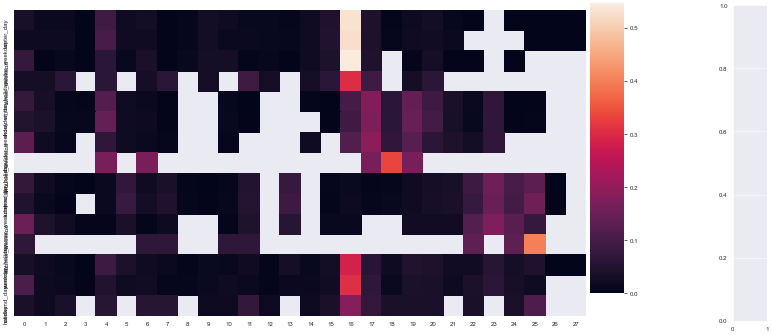

In [11]:
# Plot the means of the cluster groups
sns.set()
for folder in type_folders:
    subfolders = os.listdir(f'{start_folder}/{folder}')
    for subfolder in subfolders:
        print(subfolder)
        if subfolder == '.DS_Store':
            continue
            
        cluster_plot = ClusterGraphs(start_folder, folder, subfolder)
        
        # cluster_plot.plot_graph_1(True)
        # cluster_plot.plot_graph_2(True)
        # cluster_plot.plot_graph_3(False)
        # cluster_plot.plot_graph_4(True, 'kl')
        # cluster_plot.plot_graph_4(True, 'js')
        # cluster_plot.plot_graph_5(False)
        # cluster_plot.plot_graph_5(False, 0.90)
        cluster_plot.plot_graph_6(False, 'row')
        cluster_plot.plot_graph_6(False, 'all')
        cluster_plot.plot_graph_6(False, 'none')
        
        del cluster_plot